<a href="https://colab.research.google.com/github/AYAERROUYAS/22006522-Errouyas-Aya/blob/main/ERROUYAS_AYA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Bibliothèques importées avec succès.

2. Chargement des données depuis Kaggle...
Using Colab cache for faster access to the 'machine-predictive-maintenance-classification' dataset.
   Données chargées. Taille du dataset : (10000, 10)
   Colonnes : ['UDI', 'Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Target', 'Failure Type']

   Aperçu des données :
   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target Failure Type  
0                    1551         42.8        

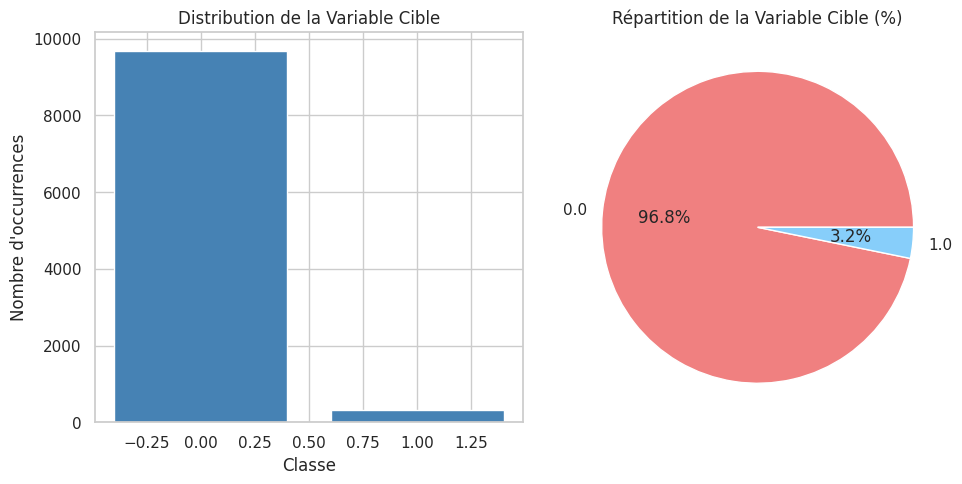

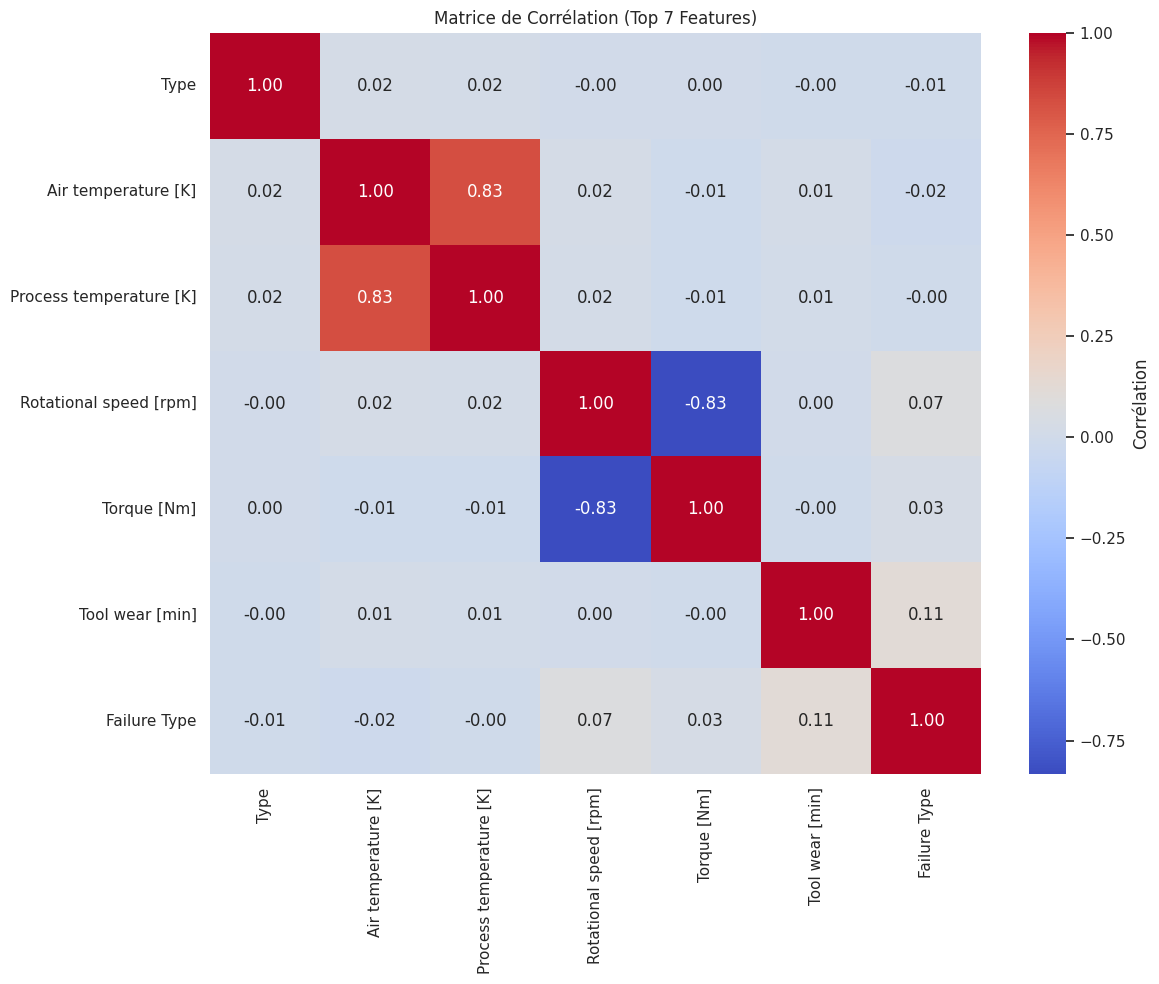

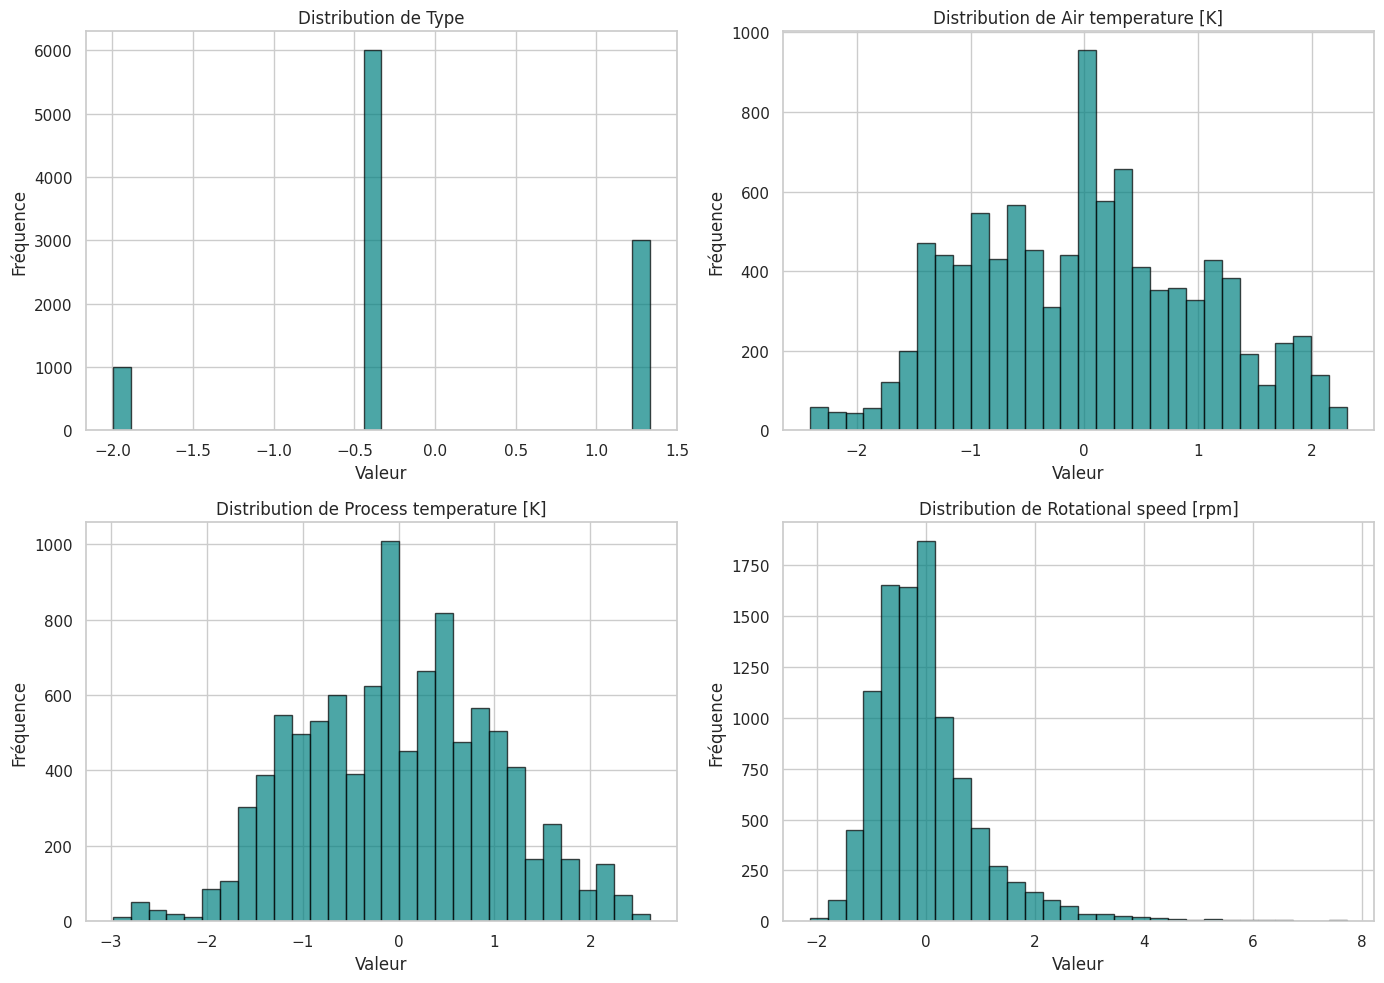


7. Séparation effectuée :
   Entraînement : 8000 échantillons
   Test : 2000 échantillons
   Nombre de features : 7

8. Entraînement du modèle (Random Forest Classifier)...
   Modèle entraîné avec succès.

9. Évaluation des performances...
   >>> Accuracy Score : 99.55%

   >>> Rapport de Classification :
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1936
         1.0       0.90      0.97      0.93        64

    accuracy                           1.00      2000
   macro avg       0.95      0.98      0.97      2000
weighted avg       1.00      1.00      1.00      2000



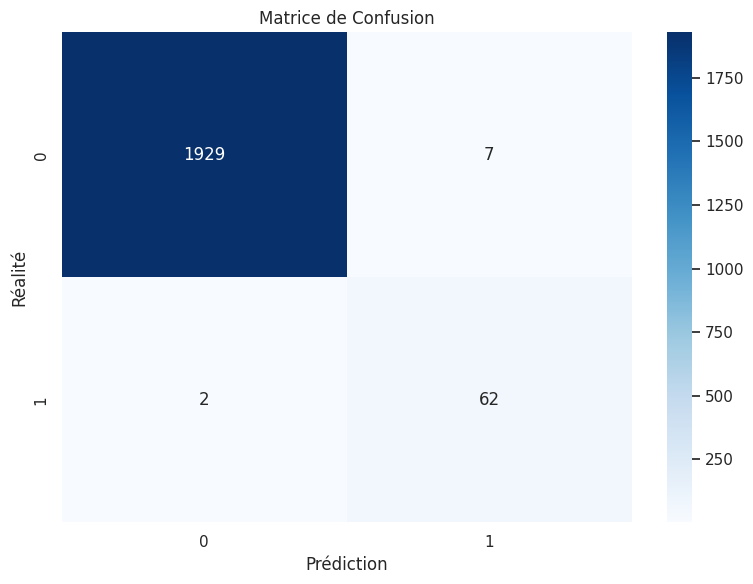


   >>> Top 10 Features les plus importantes :
                   feature  importance
6             Failure Type    0.681425
4              Torque [Nm]    0.111813
3   Rotational speed [rpm]    0.079663
5          Tool wear [min]    0.053949
1      Air temperature [K]    0.035187
2  Process temperature [K]    0.030379
0                     Type    0.007584


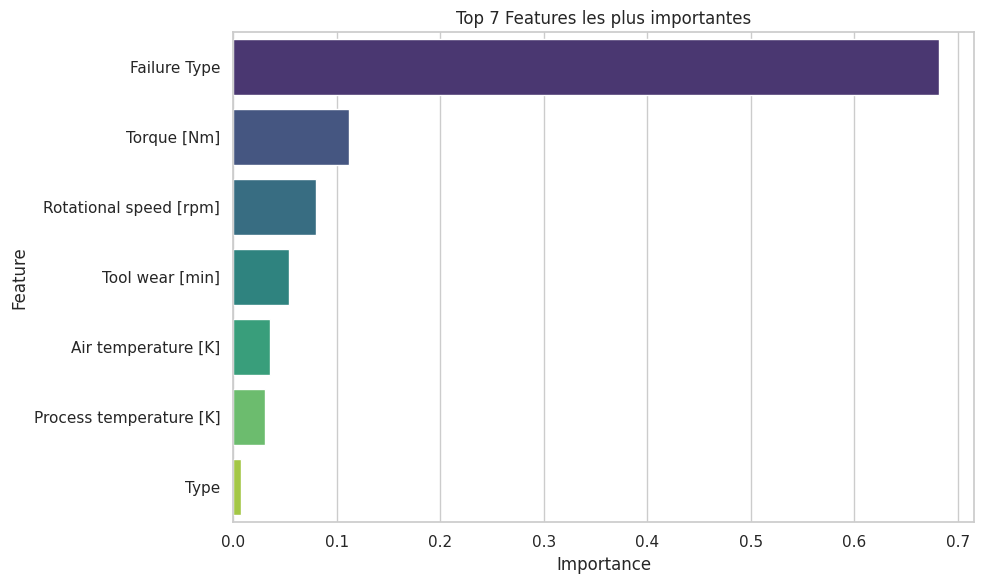


--- FIN DU SCRIPT ---


In [5]:
# ==============================================================================
# ANALYSE DE DONNÉES ET MACHINE LEARNING
# Dataset : Machine Predictive Maintenance Classification
# ==============================================================================

# 1. IMPORTATION DES BIBLIOTHÈQUES
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Modules Scikit-Learn spécifiques
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Configuration pour des graphiques plus esthétiques
sns.set_theme(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')

print("1. Bibliothèques importées avec succès.\n")

# ------------------------------------------------------------------------------
# 2. CHARGEMENT DES DONNÉES
# ------------------------------------------------------------------------------
print("2. Chargement des données depuis Kaggle...")

import kagglehub
from kagglehub import KaggleDatasetAdapter

# Chargement du dataset
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "shivamb/machine-predictive-maintenance-classification",
    "predictive_maintenance.csv" # Changed from "" to "predictive_maintenance.csv"
)

print(f"   Données chargées. Taille du dataset : {df.shape}")
print(f"   Colonnes : {list(df.columns)}\n")

# Affichage des premières lignes
print("   Aperçu des données :")
print(df.head())
print()

# ------------------------------------------------------------------------------
# 3. EXPLORATION INITIALE ET IDENTIFICATION DES PROBLÈMES
# ------------------------------------------------------------------------------
print("3. Exploration initiale des données...")

# Informations générales
print("   Informations sur les colonnes :")
print(df.info())
print()

# Vérification des valeurs manquantes
print(f"   Valeurs manquantes par colonne :")
print(df.isnull().sum())
print()

# Distribution de la variable cible (si elle existe)
if 'Target' in df.columns or 'Failure Type' in df.columns:
    target_col = 'Target' if 'Target' in df.columns else 'Failure Type'
    print(f"   Distribution de la variable cible '{target_col}' :")
    print(df[target_col].value_counts())
    print()

# ------------------------------------------------------------------------------
# 4. SIMULATION DE "DONNÉES SALES" (Pour l'exercice)
# ------------------------------------------------------------------------------
print("4. Introduction artificielle de valeurs manquantes (NaN)...")

np.random.seed(42)
df_dirty = df.copy()

# Identification des colonnes numériques
numeric_cols = df_dirty.select_dtypes(include=[np.number]).columns

# Introduction de NaN dans 5% des valeurs numériques
for col in numeric_cols:
    mask = np.random.random(len(df_dirty)) < 0.05
    df_dirty.loc[mask, col] = np.nan

print(f"   Nombre total de valeurs manquantes générées : {df_dirty.isnull().sum().sum()}\n")

# ------------------------------------------------------------------------------
# 5. NETTOYAGE ET PRÉPARATION (Data Wrangling)
# ------------------------------------------------------------------------------
print("5. Nettoyage et préparation des données...")

# A. Identification de la variable cible
if 'Target' in df_dirty.columns:
    target_column = 'Target'
elif 'Failure Type' in df_dirty.columns:
    target_column = 'Failure Type'
else:
    # Si pas de colonne cible évidente, on en créée une basée sur Machine failure
    if 'Machine failure' in df_dirty.columns:
        target_column = 'Machine failure'
    else:
        target_column = df_dirty.columns[-1]

print(f"   Variable cible identifiée : '{target_column}'")

# B. Suppression des colonnes non pertinentes (UDI, Product ID si présentes)
cols_to_drop = ['UDI', 'Product ID']
cols_to_drop = [col for col in cols_to_drop if col in df_dirty.columns]
df_clean = df_dirty.drop(columns=cols_to_drop, errors='ignore')

# C. Encodage des variables catégorielles
label_encoders = {}
categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()

# On retire la variable cible de l'encodage si elle est catégorielle
if target_column in categorical_cols:
    categorical_cols.remove(target_column)

for col in categorical_cols:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col].astype(str))
    label_encoders[col] = le
    print(f"   Colonne '{col}' encodée : {dict(enumerate(le.classes_))}")

# D. Séparation Features (X) et Target (y)
X = df_clean.drop(target_column, axis=1)
y = df_clean[target_column]

# NEW: Imputation des valeurs manquantes dans la variable cible
if y.isnull().any(): # Check if y has any NaNs
    y_imputer = SimpleImputer(strategy='most_frequent')
    # SimpleImputer expects a 2D array, so reshape y
    y = pd.Series(y_imputer.fit_transform(y.to_frame()).flatten(), index=y.index)
    print(f"   Valeurs manquantes dans la variable cible '{target_column}' imputées (stratégie: most_frequent).")

# Encodage de la cible si elle est catégorielle
if y.dtype == 'object':
    le_target = LabelEncoder()
    y = le_target.fit_transform(y)
    print(f"   Variable cible encodée : {dict(enumerate(le_target.classes_))}")

# E. Imputation des valeurs manquantes
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
X_clean = pd.DataFrame(X_imputed, columns=X.columns)

print("   Imputation terminée (NaN remplacés par la moyenne).")
print(f"   Valeurs manquantes restantes : {X_clean.isnull().sum().sum()}\n")

# F. Normalisation des features (important pour ML)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)
X_final = pd.DataFrame(X_scaled, columns=X_clean.columns)

print("   Normalisation des features effectuée.\n")

# ------------------------------------------------------------------------------
# 6. ANALYSE EXPLORATOIRE DES DONNÉES (EDA)
# ------------------------------------------------------------------------------
print("6. Analyse Exploratoire (EDA)...")

# A. Statistiques descriptives
print("   Statistiques descriptives (après nettoyage) :")
print(X_final.describe())
print()

# B. Visualisation 1 : Distribution de la variable cible
plt.figure(figsize=(10, 5))
target_counts = pd.Series(y).value_counts()
plt.subplot(1, 2, 1)
plt.bar(target_counts.index, target_counts.values, color='steelblue')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'occurrences')
plt.title('Distribution de la Variable Cible')

# Distribution en pourcentage
plt.subplot(1, 2, 2)
plt.pie(target_counts.values, labels=target_counts.index, autopct='%1.1f%%',
        colors=['lightcoral', 'lightskyblue', 'lightgreen', 'gold', 'plum'][:len(target_counts)])
plt.title('Répartition de la Variable Cible (%)')
plt.tight_layout()
plt.show()

# C. Visualisation 2 : Matrice de corrélation
if X_final.shape[1] <= 15:
    n_features = X_final.shape[1]
else:
    n_features = 10

plt.figure(figsize=(12, 10))
correlation_matrix = X_final.iloc[:, :n_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f",
            cbar_kws={'label': 'Corrélation'})
plt.title(f"Matrice de Corrélation (Top {n_features} Features)")
plt.tight_layout()
plt.show()

# D. Visualisation 3 : Distribution de quelques features clés
if X_final.shape[1] >= 3:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.ravel()

    for idx, col in enumerate(X_final.columns[:4]):
        axes[idx].hist(X_final[col], bins=30, color='teal', alpha=0.7, edgecolor='black')
        axes[idx].set_title(f'Distribution de {col}')
        axes[idx].set_xlabel('Valeur')
        axes[idx].set_ylabel('Fréquence')

    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------------------
# 7. SÉPARATION DES DONNÉES (Train / Test Split)
# ------------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n7. Séparation effectuée :")
print(f"   Entraînement : {X_train.shape[0]} échantillons")
print(f"   Test : {X_test.shape[0]} échantillons")
print(f"   Nombre de features : {X_train.shape[1]}\n")

# ------------------------------------------------------------------------------
# 8. MODÉLISATION (Machine Learning)
# ------------------------------------------------------------------------------
print("8. Entraînement du modèle (Random Forest Classifier)...")

# Initialisation du modèle
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

# Entraînement
model.fit(X_train, y_train)
print("   Modèle entraîné avec succès.\n")

# ------------------------------------------------------------------------------
# 9. ÉVALUATION ET PERFORMANCE
# ------------------------------------------------------------------------------
print("9. Évaluation des performances...")

# Prédictions
y_pred = model.predict(X_test)

# A. Accuracy Score
acc = accuracy_score(y_test, y_pred)
print(f"   >>> Accuracy Score : {acc*100:.2f}%\n")

# B. Rapport de Classification
print("   >>> Rapport de Classification :")
print(classification_report(y_test, y_pred))

# C. Matrice de Confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.title('Matrice de Confusion')
plt.tight_layout()
plt.show()

# D. Importance des Features
feature_importance = pd.DataFrame({
    'feature': X_final.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n   >>> Top 10 Features les plus importantes :")
print(feature_importance.head(10))

# Visualisation de l'importance des features
plt.figure(figsize=(10, 6))
top_n = min(15, len(feature_importance))
sns.barplot(data=feature_importance.head(top_n),
            x='importance', y='feature', palette='viridis')
plt.title(f'Top {top_n} Features les plus importantes')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("--- FIN DU SCRIPT ---")
print("="*80)
